In [1]:
import os
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import multiprocessing as mp
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.stats import bayesian_blocks
from functools import partial
from gbm.time import Met
from scipy.signal import argrelextrema,find_peaks
from scipy.special import gammaln
from scipy import interpolate
from sklearn import preprocessing
from numba import jit,njit
from numba.typed import List
np.seterr(divide='ignore',invalid='ignore')
# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

epsilon = 1e-6

@njit(nogil=True)
def FoldPhase(T,T0,P):
    phi = (T-T0)/P - np.floor((T-T0)/P)
    return phi

def Exposure(mjd_ot, observe_time, index0, index1, T0, phasebins, period):
    Times = mjd_ot[index0:index1+1]
    observe_times = observe_time[index0:index1+1]
    phis = FoldPhase(Times,T0,period)
    sortindex = np.argsort(phis)
    phis = phis[sortindex]
    observe_times = observe_times[sortindex]
    exposures = np.zeros(phasebins)
    for i,j in zip(np.arange(0, 1, 1/phasebins),range(phasebins)):
        index = np.where( (i < phis) & (phis < i+1/phasebins) & (observe_times != 1) )[0]
        if len(index)==0:
            continue
        else:
            exposures[j] =  np.sum(observe_times[index]) /len(index) 
    return exposures

def PearsonChiSquare(phasebins,phi,period,exposures):
    phasebin = 1 / phasebins
    Ni,bins=np.histogram(phi,bins = np.arange(0.,1.+phasebin,phasebin))
    p = np.sum(Ni) / np.sum(exposures)
    chi2 = np.zeros(phasebins)
    for i in range(phasebins):
        chi2[i] = (Ni[i]-p*exposures[i])**2 / p*exposures[i] 
    chi2 = np.sum(chi2) / (phasebins-1)
    return chi2

def Poissonk(miu,k):
    return np.exp(-1*miu) * miu**k / np.math.factorial(k)
def Cexpeted(miu):
    if (0 <= miu) & (miu <= 0.5):
        Ce = -0.25*miu**3 + 1.38*miu**2 - 2*miu*np.log(miu+epsilon)
    if (0.5 < miu) & (miu <= 2):
        Ce = -0.00335*miu**5 + 0.04259*miu**4 - 0.27331*miu**3 + 1.381*miu**2 - 2*miu*np.log(miu+epsilon)
    if (2 < miu) & (miu <= 5):
        Ce = 1.019275 + 0.1345*miu**(0.461 - 0.9*np.log(miu+epsilon))
    if (5 < miu) & (miu <= 10):
        Ce = 1.00624 + 0.604/(miu**1.68)
    if miu > 10:
        Ce = 1 + 0.1649/miu + 0.226/(miu**2)
    return Ce
def Cvariance(miu):
    if (0 <= miu) & (miu <= 0.1):
        Sv = 4 * np.sum([*map(lambda k:Poissonk(miu,k) * (miu-k+k*np.log(k/miu+epsilon))**2, range(1,5))])
        Cv = Sv - Cexpeted(miu)**2 ; del Sv
    if (0.1 < miu) & (miu <= 0.2):
        Cv = -262*miu**4 + 195*miu**3 - 51.24*miu**2 + 4.34*miu + 0.77005
    if (0.2 < miu) & (miu <= 0.3):
        Cv = 4.23*miu**2 - 2.8254*miu + 1.12522
    if (0.3 < miu) & (miu <= 0.5):
        Cv = -3.7*miu**3 + 7.328*miu**2 - 3.6926*miu + 1.20641
    if (0.5 < miu) & (miu <= 1):
        Cv = 1.28*miu**4 - 5.191*miu**3 + 7.666*miu**2 - 3.5446*miu + 1.15431
    if (1 < miu) & (miu <=2):
        Cv = 0.1125*miu**4 - 0.641*miu**3 + 0.859*miu**2 + 1.0914*miu - 0.05748
    if (2 < miu) & (miu <=3):
        Cv = 0.089*miu**3 - 0.872*miu**2 + 2.8422*miu - 0.67539
    if (3 < miu) & (miu <=5):
        Cv = 2.12336 + 0.012202*miu**(5.717 - 2.6*np.log(miu+epsilon))
    if (5 < miu) & (miu <=10):
        Cv = 2.05159 + 0.331*miu**(1.343-np.log(miu+epsilon))
    if miu > 10:
        Cv = 12/(miu**3) + 0.79/(miu**2) + 0.6747/miu + 2
    return Cv

def Cstat(phasebins,phi,period,exposures):
    phasebin = 1 / phasebins
    Ni,bins=np.histogram(phi,bins = np.arange(0.,1.+phasebin,phasebin))
    p = np.sum(Ni) / np.sum(exposures)
    cstat, Ce, Cv = np.zeros(phasebins),np.zeros(phasebins),np.zeros(phasebins)
    for i in range(phasebins):
        if Ni[i] == 0:
            cstat[i] =  p*exposures[i]
        else:
            cstat[i] =  p*exposures[i] - Ni[i] + Ni[i] * np.log( epsilon + Ni[i] / p*exposures[i] ) 
        Ce[i] =  Cexpeted(p*exposures[i]) 
        Cv[i] =  Cvariance(p*exposures[i]) 
    C_Ce_Cv = ( 2 * np.sum(cstat) - np.sum(Ce) ) / np.sqrt(np.sum(Cv))
    return C_Ce_Cv


In [2]:
n = 9
# 数据
Data_for_plot = pd.read_excel('List_SGR1935.xlsx',sheet_name=0)
utc_for_plot = Data_for_plot.iloc[:,0].values
mjd_for_plot = np.array([math.floor(Time(utc_for_plot[i], format='isot', scale='utc').mjd*(10**n))/(10**n) for i in range(len(utc_for_plot))])
flag = np.array(Data_for_plot.iloc[:,2].values)
# 曝光时间
OT = pd.read_excel('ObserveTime.xlsx',sheet_name='Bin1day')
mjd_ot = np.array(OT['Time_MJD'])
observe_time = np.array(OT['Observe_Time'])
OT_bin = pd.read_excel('ObserveTime.xlsx',sheet_name='Bin0.05day')
mjd_bin_ot = np.array(OT_bin['Time_MJD'])
observe_bin_time = np.array(OT_bin['Observe_Time'])

# 模拟观测窗口周期
data = pd.read_csv('simulation.csv')
simu_time_series,simu_signal = data['simu_time_series'],data['simu_signal']; del data
simu_frequency, simu_power = LombScargle(simu_time_series - 56658, simu_signal).autopower(minimum_frequency=1/1000,
                                                                            maximum_frequency = 1/2,
                                                                            normalization='standard')


mjd_sampleA = mjd_for_plot[np.where(flag != 'Candidate')]
mjd_sampleB = mjd_for_plot


In [3]:
# Observation time and bursts rate 

T0_A = 56658    # 54690(2008-08-12) 56658(2014-01-01) 54771(2008-11-01)
T0_B = 54771
T100 = 59599  # 59487(2021-09-30) 59579(2021-12-31) 59599(2022-01-20)
Bin = 0.05

# sampleA
time_series_A = np.array(mjd_sampleA) - T0_A
rates_A,times_A=np.histogram(time_series_A,bins = np.round(np.arange(0,T100-T0_A,Bin),len(str(Bin).split(".")[1])))
times_A = times_A[:-1]

observe_bin_time = observe_bin_time / Bin      # exposure time / bin
index0_A = np.where(T0_A<=mjd_ot)[0][0]
index1_A = np.where(mjd_ot<=T100)[0][-1]
index2_A = np.where(T0_A<=mjd_bin_ot)[0][0]
index3_A = np.where(mjd_bin_ot<=T100)[0][-1]
for i in range(len(times_A)):
    if times_A[i] + T0_A != mjd_bin_ot[index2_A+i]:
        for j in np.round(np.arange(times_A[i]+T0_A,times_A[i] + T0_A+Bin,Bin),len(str(Bin).split(".")[1])):
            print(j)
        raise
norm_rates_A = np.zeros(len(rates_A))
for i in range(len(rates_A)):
    if observe_bin_time[index2_A+i]==0:
        continue
    else:
        norm_rates_A[i] = rates_A[i] / observe_bin_time[index2_A+i]

# sampleB
time_series_B = np.array(mjd_sampleB) - T0_B
rates_B,times_B=np.histogram(time_series_B,bins = np.round(np.arange(0,T100-T0_B,Bin),len(str(Bin).split(".")[1])))
times_B = times_B[:-1]

observe_bin_time = observe_bin_time / Bin      # exposure time / bin
index0_B = np.where(T0_B<=mjd_ot)[0][0]
index1_B = np.where(mjd_ot<=T100)[0][-1]
index2_B = np.where(T0_B<=mjd_bin_ot)[0][0]
index3_B = np.where(mjd_bin_ot<=T100)[0][-1]
for i in range(len(times_B)):
    if times_B[i] + T0_B != mjd_bin_ot[index2_B+i]:
        for j in np.round(np.arange(times_B[i]+T0_B,times_B[i] + T0_B+Bin,Bin),len(str(Bin).split(".")[1])):
            print(j)
        raise
norm_rates_B = np.zeros(len(rates_B))
for i in range(len(rates_B)):
    if observe_bin_time[index2_B+i]==0:
        continue
    else:
        norm_rates_B[i] = rates_B[i] / observe_bin_time[index2_B+i]

In [4]:
# LombScargle   sampleA
min_period, max_period = 2, 600
frequency, power = LombScargle(times_A, norm_rates_A).autopower(minimum_frequency=1/max_period,
                                                            maximum_frequency = 1/min_period,
                                                            normalization='standard')
# Relative Periodogram
Pmax = 600; Pmin = 2
index = np.where( (Pmin<=1/frequency) & (1/frequency<=Pmax) )[0]
index_simu = np.where( (Pmin<=1/simu_frequency) & (1/simu_frequency<=Pmax) )[0]
period_series = 1/frequency[index]
simu_period_series = 1/simu_frequency[index_simu]
max_abs_scaler = preprocessing.MaxAbsScaler()           # MaxAbsScaler,MinMaxScaler,StandardScaler
norm_power = max_abs_scaler.fit_transform(power[index].reshape(-1,1)).T[0]
norm_simu_power = max_abs_scaler.fit_transform(simu_power[index_simu].reshape(-1,1)).T[0]
xnew = np.array(sorted(np.arange(Pmin, Pmax, 0.01), reverse=True))
func1 = interpolate.interp1d(period_series, norm_power, kind='cubic',fill_value="extrapolate")
func2 = interpolate.interp1d(simu_period_series, norm_simu_power, kind='cubic',fill_value="extrapolate")
power_new = func1(xnew)
simu_power_new = func2(xnew)
relative_power = power_new-simu_power_new
# Pearson chi2 and Cstat
phasebins = 20
fmax = 1 / Pmin; fmin = 1 / Pmax
fbin = 0.1 / (T100-T0_A)
Frequency = np.arange(fmin, fmax+fbin, fbin)
Period = np.array(sorted([*map(lambda x:1/x, Frequency)]))
Phi = []; chi2 = []; Exposures = []; cstat = []
for i in range(len(Period)):
    Phi.append(FoldPhase(mjd_sampleA,T0_A,Period[i]))
    Exposures.append(Exposure(mjd_ot, observe_time, index0_A, index1_A, T0_A, phasebins, Period[i]))
    chi2.append(PearsonChiSquare(phasebins,Phi[i],Period[i],Exposures[i]))
    cstat.append(Cstat(phasebins,Phi[i],Period[i],Exposures[i]))

peaks = argrelextrema(power,np.greater); period_peaks = 1/frequency[peaks]
print('LombScargle Peaks\n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 160))])

peaks = argrelextrema(relative_power,np.greater); period_peaks = xnew[peaks]
print('Relative LombScargle Peaks\n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 600))])

peaks = argrelextrema(np.array(chi2),np.greater); period_peaks = Period[peaks]
print('ReducedChi2 Peaks\n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 160))])

peaks = argrelextrema(np.array(cstat),np.greater); period_peaks = Period[peaks]
print('Cstat \n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 160))])

LombScargle Peaks
  [157.25476566 147.77278095 127.30342186 120.02938596]
Relative LombScargle Peaks
  [492.42 399.03 333.8  277.18 235.47 209.6  187.21 170.46 157.95 147.59
 126.88]
ReducedChi2 Peaks
  [120.03265084 122.02475624 124.08410098 125.67480949 127.30683212
 129.54995962 132.46753247 135.51954535 138.71550979 140.03650504
 144.15488931 147.77656813 149.27671094 150.80762328 156.42230299
 158.95865237]
Cstat 
  [120.03265084 122.02475624 125.67480949 127.30683212 129.54995962
 132.46753247 136.14690225 138.71550979 140.03650504 144.15488931
 147.77656813 149.27671094 150.80762328 156.42230299 158.95865237]


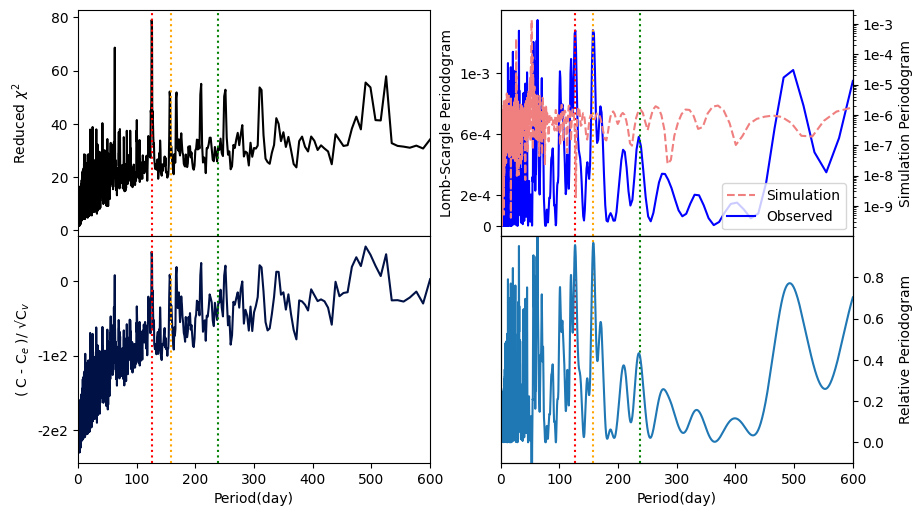

In [5]:
fig, axs = plt.subplots(figsize=(10, 6), dpi=100, sharex=True)
fig.subplots_adjust(wspace=None, hspace=0)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(Period, chi2,  label='$\chi$', color = 'black')
plt.ylabel('Reduced $\chi^2$')
plt.xlim([0,Pmax])
plt.xticks([])

ax2 = plt.subplot(2, 2, 2)
ax2.plot(1/frequency, power,label='Observed',color = 'blue')
plt.yticks([0,2e-4,6e-4,1e-3],['0','2e-4','6e-4','1e-3'])
plt.ylabel('Lomb-Scargle Periodogram')
ax2r = ax2.twinx()
ax2r.set_yscale('log')
ax2r.plot(1/simu_frequency, simu_power,label='Simulation', linestyle='dashed', color = 'lightcoral')
ax2r.plot([1000],[0],label='Observed', color = 'blue')     # just for plot legend
plt.yticks([1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9],['1e-3','1e-4','1e-5','1e-6','1e-7','1e-8','1e-9'])
plt.ylabel('Simulation Periodogram')
plt.xlim([0,Pmax])
plt.xticks([])
plt.legend(loc=4)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(Period, cstat,  label='Cstat', color = '#001146')  # #8c564b
plt.xlabel('Period(day)')
plt.ylabel('( C - C$_{e}$ )/ \u221AC$_{v}$')
plt.yticks([0,-100,-200],['0','-1e2','-2e2'])
plt.xlim([0,Pmax])
# plt.legend(loc=4)

ax4 = plt.subplot(2, 2, 4)
plt.xlabel('Period(day)')
plt.yticks([])
ax4r = ax4.twinx()
ax4r.plot(xnew, relative_power)
plt.yticks(np.arange(0,1,0.2))
plt.ylabel('Relative Periodogram')
plt.ylim(-0.1,1)
plt.xlim(0,Pmax)

[axe.axvline(126.88, color='red', linestyle='dotted') for axe in [ax1,ax2,ax3,ax4]]
[axe.axvline(158.15, color='orange', linestyle='dotted') for axe in [ax1,ax2,ax3,ax4]]
[axe.axvline(238, color='green', linestyle='dotted') for axe in [ax1,ax2,ax3,ax4]]
fig.align_ylabels([ax1,ax3,ax2r,ax4r])
plt.savefig('figure/sampleA.pdf', format='pdf')
plt.show()

In [6]:
# LombScargle   sampleB
min_period, max_period = 2, 600
frequency, power = LombScargle(times_B, norm_rates_B).autopower(minimum_frequency=1/max_period,
                                                            maximum_frequency = 1/min_period,
                                                            normalization='standard')
# Relative Periodogram
Pmax = 600; Pmin = 2
index = np.where( (Pmin<=1/frequency) & (1/frequency<=Pmax) )[0]
index_simu = np.where( (Pmin<=1/simu_frequency) & (1/simu_frequency<=Pmax) )[0]
period_series = 1/frequency[index]
simu_period_series = 1/simu_frequency[index_simu]
max_abs_scaler = preprocessing.MaxAbsScaler()           # MaxAbsScaler,MinMaxScaler,StandardScaler
norm_power = max_abs_scaler.fit_transform(power[index].reshape(-1,1)).T[0]
norm_simu_power = max_abs_scaler.fit_transform(simu_power[index_simu].reshape(-1,1)).T[0]
xnew = np.array(sorted(np.arange(Pmin, Pmax, 0.01), reverse=True))
func1 = interpolate.interp1d(period_series, norm_power, kind='cubic',fill_value="extrapolate")
func2 = interpolate.interp1d(simu_period_series, norm_simu_power, kind='cubic',fill_value="extrapolate")
power_new = func1(xnew)
simu_power_new = func2(xnew)
relative_power = power_new-simu_power_new
# Pearson chi2 and Cstat
phasebins = 20
fmax = 1 / Pmin; fmin = 1 / Pmax
fbin = 0.1 / (T100-T0_A)
Frequency = np.arange(fmin, fmax+fbin, fbin)
Period = np.array(sorted([*map(lambda x:1/x, Frequency)]))
Phi = []; chi2 = []; Exposures = []; cstat = []
for i in range(len(Period)):
    Phi.append(FoldPhase(mjd_sampleB,T0_B,Period[i]))
    Exposures.append(Exposure(mjd_ot, observe_time, index0_B, index1_B, T0_B, phasebins, Period[i]))
    chi2.append(PearsonChiSquare(phasebins,Phi[i],Period[i],Exposures[i]))
    cstat.append(Cstat(phasebins,Phi[i],Period[i],Exposures[i]))

peaks = argrelextrema(power,np.greater); period_peaks = 1/frequency[peaks]
print('LombScargle Peaks\n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 160))])

peaks = argrelextrema(relative_power,np.greater); period_peaks = xnew[peaks]
print('Relative LombScargle Peaks\n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 600))])

peaks = argrelextrema(np.array(chi2),np.greater); period_peaks = Period[peaks]
print('ReducedChi2 Peaks\n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 160))])

peaks = argrelextrema(np.array(cstat),np.greater); period_peaks = Period[peaks]
print('Cstat \n ',period_peaks[np.where((period_peaks > 120) & (period_peaks < 160))])

LombScargle Peaks
  [158.56995057 146.98369689 126.89472093]
Relative LombScargle Peaks
  [488.16 398.89 331.09 280.73 235.34 209.57 187.07 170.35 158.11 147.3
 127.02]
ReducedChi2 Peaks
  [120.03265084 121.52055644 123.56277572 125.67480949 127.86029998
 131.28487464 135.51954535 138.71550979 140.70648274 145.58204769
 147.77656813 149.27671094 151.58491539 153.96562255 156.42230299]
Cstat 
  [120.03265084 121.52055644 122.53315742 123.56277572 125.67480949
 127.86029998 128.98179958 131.28487464 135.51954535 137.41920411
 138.71550979 140.70648274 145.58204769 147.77656813 149.27671094
 150.80762328 153.96562255 156.42230299]


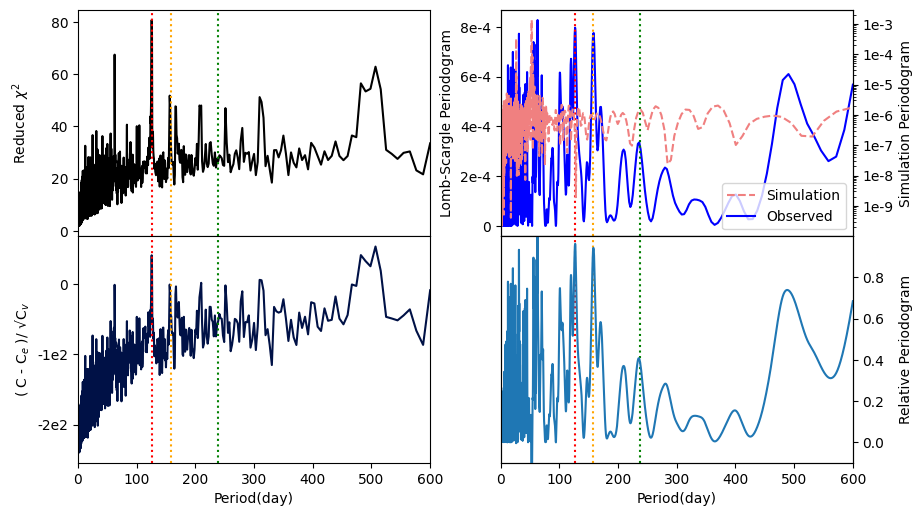

In [7]:
fig, axs = plt.subplots(figsize=(10, 6), dpi=100, sharex=True)
fig.subplots_adjust(wspace=None, hspace=0)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(Period, chi2,  label='$\chi$', color = 'black')
plt.ylabel('Reduced $\chi^2$')
plt.xlim([0,Pmax])
plt.xticks([])

ax2 = plt.subplot(2, 2, 2)
ax2.plot(1/frequency, power,label='Observed',color = 'blue')
plt.yticks([0,2e-4,4e-4,6e-4,8e-4],['0','2e-4','4e-4','6e-4','8e-4'])
plt.ylabel('Lomb-Scargle Periodogram')
ax2r = ax2.twinx()
ax2r.set_yscale('log')
ax2r.plot(1/simu_frequency, simu_power,label='Simulation', linestyle='dashed', color = 'lightcoral')
ax2r.plot([1000],[0],label='Observed', color = 'blue')     # just for plot legend
plt.yticks([1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9],['1e-3','1e-4','1e-5','1e-6','1e-7','1e-8','1e-9'])
plt.ylabel('Simulation Periodogram')
plt.xlim([0,Pmax])
plt.xticks([])
plt.legend(loc=4)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(Period, cstat,  label='Cstat', color = '#001146')  # 8c564b 001146
plt.xlabel('Period(day)')
plt.ylabel('( C - C$_{e}$ )/ \u221AC$_{v}$')
plt.yticks([0,-100,-200],['0','-1e2','-2e2'])
plt.xlim([0,Pmax])
# plt.legend(loc=4)

ax4 = plt.subplot(2, 2, 4)
plt.xlabel('Period(day)')
plt.yticks([])
ax4r = ax4.twinx()
ax4r.plot(xnew, relative_power)
plt.yticks(np.arange(0,1,0.2))
plt.ylabel('Relative Periodogram')
plt.ylim(-0.1,1)
plt.xlim(0,Pmax)

[axe.axvline(126.88, color='red', linestyle='dotted') for axe in [ax1,ax2,ax3,ax4]]
[axe.axvline(158.15, color='orange', linestyle='dotted') for axe in [ax1,ax2,ax3,ax4]]
[axe.axvline(238, color='green', linestyle='dotted') for axe in [ax1,ax2,ax3,ax4]]
fig.align_ylabels([ax1,ax3,ax2r,ax4r])
plt.savefig('figure/sampleB.pdf', format='pdf')
plt.show()

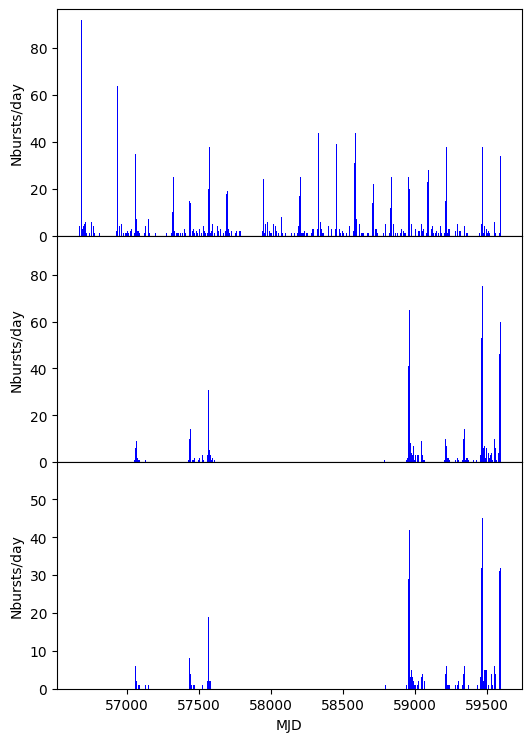

In [8]:
# simulated bursts(No Gap)  T0 56658
with open( 'T0_56658/SimulationBusrt_NoGap.pkl' , "rb" ) as Input_Object :
    [simu_burst_series_nogap,simu_burst_times_nogap,simu_burst_norm_rates_nogap,simu_burst_frequency_nogap,simu_burst_power_nogap,Period_nogap,chi2_nogap,cstat_nogap] = pickle.load( Input_Object )
# simulated bursts(Gap)
with open( 'T0_56658/SimulationBusrt_Gap.pkl' , "rb" ) as Input_Object :
    [simu_burst_series_gap,simu_burst_times_gap,simu_burst_rm_rates_gap,simu_burst_frequency_gap,simu_burst_power_gap,Period_gap,chi2_gap,cstat_gap] = pickle.load( Input_Object )
# simulated bursts(GapNoWin)
with open( 'T0_56658/SimulationBusrt_GapNoWin.pkl' , "rb" ) as Input_Object :
    [simu_burst_series_gapnowin,simu_burst_times_gapnowin,simu_burst_rm_rates_gapnowin,simu_burst_frequency_gapnowin,simu_burst_power_gapnowin,Period_gapnowin,chi2_gapnowin,cstat_gapnowin] = pickle.load( Input_Object )

# Plot figure
# Bursts histogram
fig, axs = plt.subplots(figsize=(6, 9), dpi=100, sharex=True)  # figsize=(6, 6)
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(3, 1, 1)
ax1.hist(x = simu_burst_series_nogap,bins = range(T0_A,T100),label='Simulation Bursts', color='b')  # color='b'
plt.ylabel('Nbursts/day')

ax2 = plt.subplot(3, 1, 2)
ax2.hist(x = simu_burst_series_gapnowin,bins = range(T0_A,T100),label='Simulation Bursts', color='b')  # color='b'
plt.ylabel('Nbursts/day')

ax3 = plt.subplot(3, 1, 3)
ax3.hist(x = simu_burst_series_gap,bins = range(T0_A,T100),label='Simulation Bursts', color='b')  # color='b'
plt.ylabel('Nbursts/day')

plt.xlabel('MJD')
fig.align_ylabels([ax1,ax2,ax3])
plt.savefig('figure/simu_bursts.pdf', format='pdf')
plt.show()

In [10]:
# weighted simulated bursts
# NoGap 
Period_nogap = np.array(sorted(np.arange(Pmin, Pmax, 0.01), reverse=True))
#
simu_burst_frequency_nogap = []
simu_burst_power_nogap = []
chi2_nogap = []
cstat_nogap = []
for i in range(1,11):
    with open( 'T0_56658/SimulationBusrt_NoGap_%02d.pkl'%i , "rb" ) as Input_Object :
        [simu_burst_series,simu_burst_times,simu_burst_norm_rates,simu_burst_frequency,simu_burst_power,Period,chi2,cstat] = pickle.load( Input_Object )
        simu_burst_frequency_nogap.append( simu_burst_frequency )
        simu_burst_power_nogap.append( simu_burst_power )
        #
        func1 = interpolate.interp1d(Period, chi2, kind='cubic',fill_value="extrapolate")
        chi2_nogap.append( func1(Period_nogap) )
        #
        cstat = np.nan_to_num(cstat, nan=np.min(np.array(cstat)[~np.isnan(cstat)]))
        func2 = interpolate.interp1d(Period, cstat, kind='cubic',fill_value="extrapolate")
        cstat_nogap.append( func2(Period_nogap) )
#
simu_burst_frequency_nogap = np.mean(simu_burst_frequency_nogap,axis=0)
simu_burst_power_nogap = np.mean(simu_burst_power_nogap, axis=0)
chi2_nogap = np.mean(chi2_nogap,axis=0)
cstat_nogap = np.mean(cstat_nogap,axis=0)
# Gap 
Period_gap = np.array(sorted(np.arange(Pmin, Pmax, 0.01), reverse=True))
#
simu_burst_frequency_gap = []
simu_burst_power_gap = []
chi2_gap = []
cstat_gap = []
for i in range(1,11):
    with open( 'T0_56658/SimulationBusrt_Gap_%02d.pkl'%i , "rb" ) as Input_Object :
        [simu_burst_series,simu_burst_times,simu_burst_norm_rates,simu_burst_frequency,simu_burst_power,Period,chi2,cstat] = pickle.load( Input_Object )
        simu_burst_frequency_gap.append( simu_burst_frequency )
        simu_burst_power_gap.append( simu_burst_power )
        #
        func1 = interpolate.interp1d(Period, chi2, kind='cubic',fill_value="extrapolate")
        chi2_gap.append( func1(Period_gap) )
        #
        cstat = np.nan_to_num(cstat, nan=np.min(np.array(cstat)[~np.isnan(cstat)]))
        func2 = interpolate.interp1d(Period, cstat, kind='cubic',fill_value="extrapolate")
        cstat_gap.append( func2(Period_gap) )
#
simu_burst_frequency_gap = np.mean(simu_burst_frequency_gap,axis=0)
simu_burst_power_gap = np.mean(simu_burst_power_gap,axis=0)
chi2_gap = np.mean(chi2_gap,axis=0)
cstat_gap = np.mean(cstat_gap,axis=0)
# GapNoWin
Period_gapnowin = np.array(sorted(np.arange(Pmin, Pmax, 0.01), reverse=True))
#
simu_burst_frequency_gapnowin = []
simu_burst_power_gapnowin = []
chi2_gapnowin = []
cstat_gapnowin = []
for i in range(1,11):
    with open( 'T0_56658/SimulationBusrt_GapNoWin_%02d.pkl'%i , "rb" ) as Input_Object :
        [simu_burst_series,simu_burst_times,simu_burst_norm_rates,simu_burst_frequency,simu_burst_power,Period,chi2,cstat] = pickle.load( Input_Object )
        simu_burst_frequency_gapnowin.append( simu_burst_frequency )
        simu_burst_power_gapnowin.append( simu_burst_power )
        #
        func1 = interpolate.interp1d(Period, chi2, kind='cubic',fill_value="extrapolate")
        chi2_gapnowin.append( func1(Period_gapnowin) )
        #
        cstat = np.nan_to_num(cstat, nan=np.min(np.array(cstat)[~np.isnan(cstat)]))
        func2 = interpolate.interp1d(Period, cstat, kind='cubic',fill_value="extrapolate")
        cstat_gapnowin.append( func2(Period_gapnowin) )
#
simu_burst_frequency_gapnowin = np.mean(simu_burst_frequency_gapnowin,axis=0)
simu_burst_power_gapnowin = np.mean(simu_burst_power_gapnowin,axis=0)
chi2_gapnowin = np.mean(chi2_gapnowin,axis=0)
cstat_gapnowin = np.mean(cstat_gapnowin,axis=0)

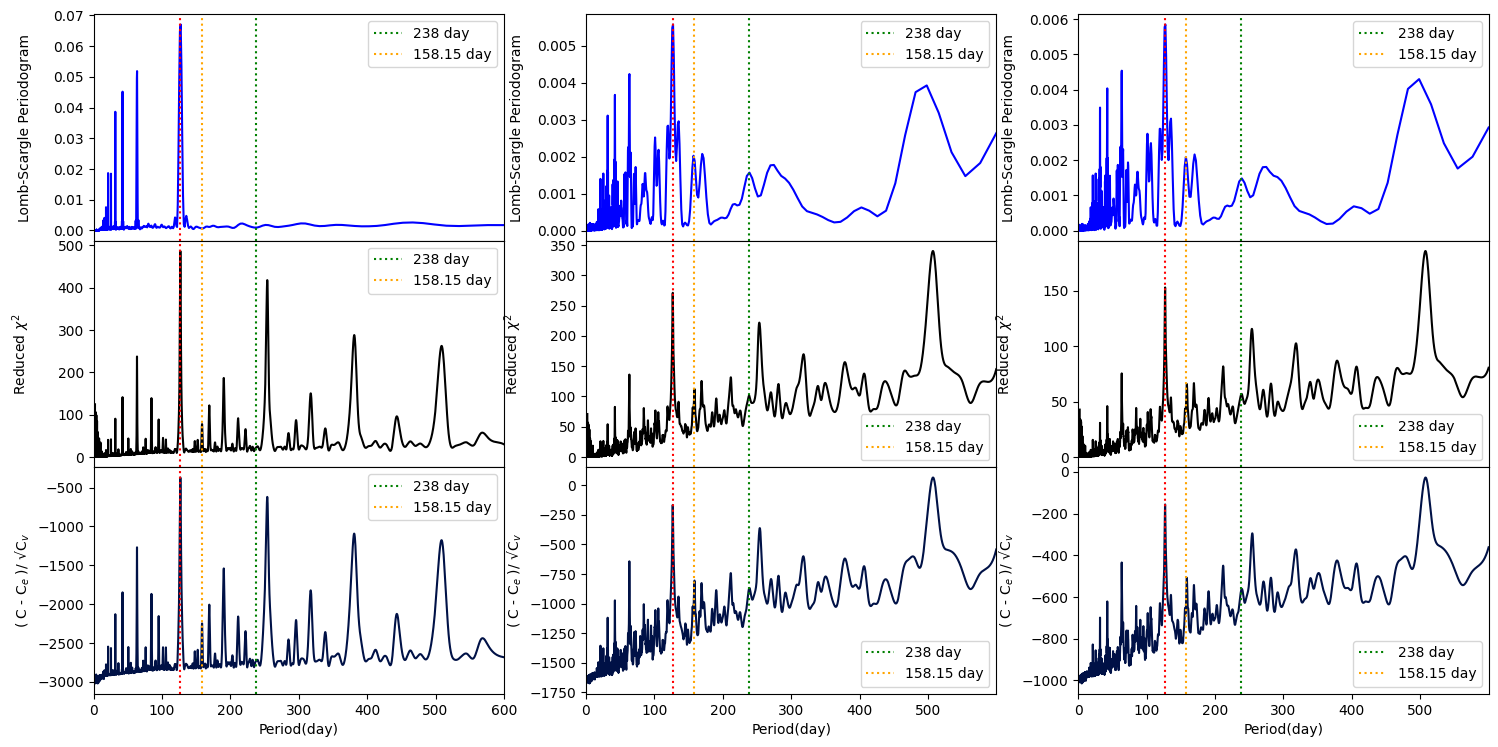

In [11]:
fig, axs = plt.subplots(figsize=(18, 9), dpi=100, sharex=True)    # figsize=(12, 9)
fig.subplots_adjust(hspace=0)  # wspace=0
# # NoGap
ax1 = plt.subplot(3, 3, 1)
ax1.plot(1/simu_burst_frequency_nogap, simu_burst_power_nogap, color='blue')  # label='Simulation Bursts'
ax1.axvline(238, ls=':', c='green', label='238 day')
ax1.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax);plt.ylim()
plt.ylabel('Lomb-Scargle Periodogram')
plt.legend(loc=1)    # 4 
plt.xticks([])
#
ax2 = plt.subplot(3, 3, 4)
ax2.plot(Period_nogap, chi2_nogap, color='black')  # label='Simulation Bursts'
ax2.axvline(238, ls=':', c='green', label='238 day')
ax2.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax)
plt.ylabel('Reduced $\chi^2$')
plt.legend(loc=1)
plt.xticks([])
#
ax3 = plt.subplot(3, 3, 7)
plt.xlabel('Period(day)')
ax3.plot(Period_nogap, cstat_nogap, color='#001146')
ax3.axvline(238, ls=':', c='green', label='238 day')
ax3.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax)
plt.ylabel('( C - C$_{e}$ )/ \u221AC$_{v}$')
plt.legend(loc=1)
# # GapNoWin
ax4 = plt.subplot(3, 3, 2)
ax4.plot(1/simu_burst_frequency_gapnowin, simu_burst_power_gapnowin, color='blue')  # label='Simulation Bursts'
ax4.axvline(238, ls=':', c='green', label='238 day')
ax4.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax);plt.ylim()
plt.ylabel('Lomb-Scargle Periodogram')
plt.legend(loc=1)    # 4 右下
plt.xticks([])
#
ax5 = plt.subplot(3, 3, 5)
ax5.plot(Period_gapnowin, chi2_gapnowin, color='black')  # label='Simulation Bursts'
ax5.axvline(238, ls=':', c='green', label='238 day')
ax5.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax)
plt.ylabel('Reduced $\chi^2$')
plt.legend(loc=4)
plt.xticks([])
#
ax6 = plt.subplot(3, 3, 8)
ax6.plot(Period_gapnowin, cstat_gapnowin, color='#001146')  # 001146 8c564b
ax6.axvline(238, ls=':', c='green', label='238 day')
ax6.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xticks([0,100,200,300,400,500])
plt.xlim(0,Pmax)
plt.xlabel('Period(day)');plt.ylabel('( C - C$_{e}$ )/ \u221AC$_{v}$')
plt.legend(loc=4)
# # Gap
ax7 = plt.subplot(3, 3, 3)
ax7.plot(1/simu_burst_frequency_gap, simu_burst_power_gap, color='blue')  # label='Simulation Bursts'
ax7.axvline(238, ls=':', c='green', label='238 day')
ax7.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax);plt.ylim()
plt.ylabel('Lomb-Scargle Periodogram')
plt.legend(loc=1)    # 4 右下
plt.xticks([])
#
ax8 = plt.subplot(3, 3, 6)
ax8.plot(Period_gap, chi2_gap, color='black')  # label='Simulation Bursts'
ax8.axvline(238, ls=':', c='green', label='238 day')
ax8.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xlim(0,Pmax)
plt.ylabel('Reduced $\chi^2$')
plt.legend(loc=4)
plt.xticks([])
#
ax9 = plt.subplot(3, 3, 9)
ax9.plot(Period_gap, cstat_gap, color='#001146')  # 001146 8c564b
ax9.axvline(238, ls=':', c='green', label='238 day')
ax9.axvline(158.15, ls=':', c='orange', label='158.15 day')
plt.xticks([0,100,200,300,400,500])
plt.xlim(0,Pmax)
plt.xlabel('Period(day)');plt.ylabel('( C - C$_{e}$ )/ \u221AC$_{v}$')
plt.legend(loc=4)

[axe.axvline(126.88, color='red', linestyle=':') for axe in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]]
fig.align_ylabels([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9])
plt.savefig('figure/simu_bursts_pt.pdf', dpi=100, format='pdf')
plt.show()

Period: 126.88 Wactive: 44.407999999999994 Phase Bins: 20
Error: 2.0463892759482567
Bayesian Block:
 [0.    0.075 0.125 0.175 0.375 0.725 0.775 0.95 ]


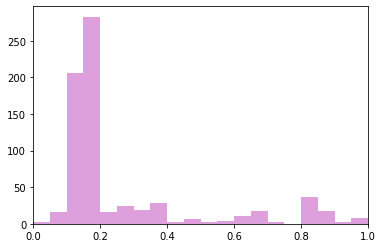

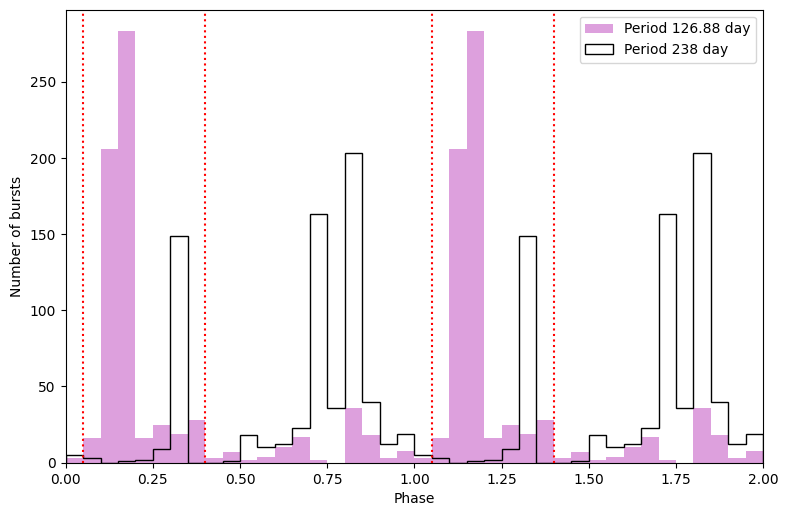

In [6]:
period = 126.88
phasebins = 20
Wactive = period*0.35

mjd_for_phasefold = mjd_sampleA
phase = FoldPhase(mjd_for_phasefold,T0_A,period)   # T0_A+70
phase2 = np.hstack( [phase, phase+1] )

numbers, bins=np.histogram(phase, bins=np.arange(0.,1.+1./phasebins,1./phasebins))
edges = bayesian_blocks(bins[:-1], numbers,sigma = np.sqrt(numbers) ,fitness='events', p0=0.01)
bay_num, bay_bins = np.histogram(phase2, weights=None, bins=np.hstack([edges, edges+1]))

print('Period:',period, 'Wactive:',Wactive, 'Phase Bins:',phasebins)
print('Error:',period*Wactive / (mjd_for_phasefold[-1]-mjd_for_phasefold[0]))
print('Bayesian Block:\n',edges)

data_zou = pd.read_csv('SGR1935_from_Zou.csv')
met_zou = np.array([*map(lambda x:Met.from_iso(x[0]).mjd, np.array(data_zou))])
phase_zou = FoldPhase(mjd_sampleA,T0_A,238)       # T0_A+30
phase_zou2 = np.hstack( [phase_zou, phase_zou+1] )

fig = plt.figure()   # figsize=(14, 10), dpi=60
plt.hist(x = phase, bins = np.arange(0.,1.+1./phasebins,1./phasebins), color='plum', label='Period 126.88 day')
plt.xlim(0,1)

fig = plt.figure(figsize=(9, 6), dpi=100)
plt.hist(x = phase2, bins = np.arange(0.,2.+1./phasebins,1./phasebins), color='plum', label='Period 126.88 day')
plt.hist(x = phase_zou2, bins = np.arange(0.,2.+1./phasebins,1./phasebins), histtype='step', color='w', edgecolor='black', label='Period 238 day')
# plt.hist(bay_bins[:-1], bay_bins, weights=(1/phasebins)*bay_num/(bay_bins[1:] - bay_bins[:-1]), histtype='step', color='w', edgecolor='black',label='Bayesian Block')

for ver_line in [0.05, 0.4, 1.05, 1.4]:    # [0.5, 0.85, 1.5, 1.85]
    plt.axvline(ver_line, ls=':', c='red')
plt.xlim(0,2)
plt.xlabel('Phase');plt.ylabel('Number of bursts')
plt.legend()
plt.savefig('figure/phase.pdf', format='pdf')
plt.show()

Period:  126.88


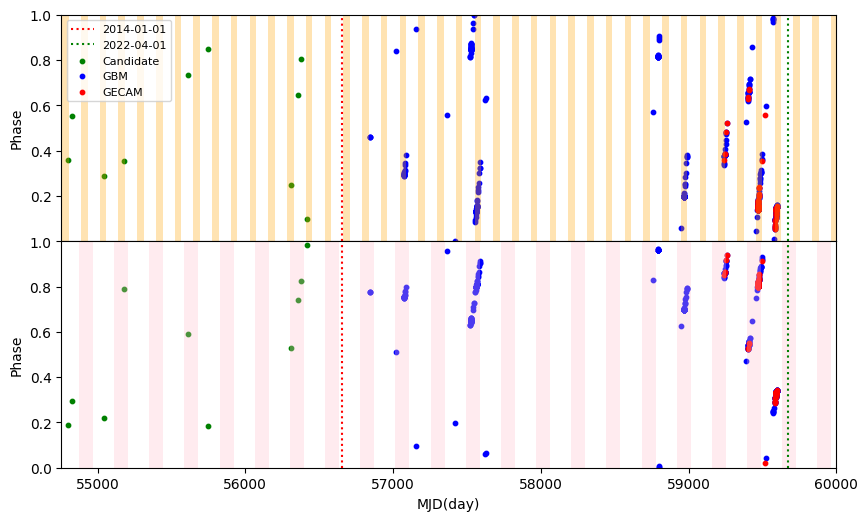

In [5]:
# MJD-BurstNumbers

T_Start = 54754.8    # 54000(2006-09-22) 56658(2014-01-01) 54771(2008-11-01)  54754.8(2008-10-15T19:12)
T_End = 60000  # 59487(2021-09-30) 59579(2021-12-31) 59599(2022-01-20) 60000(2023-02-25)
period = 126.88
main_phase = [0.05,0.4]   # [0.775,1.375]  [0.075,0.375]  [0.05,0.4]

mjd_candidate = mjd_for_plot[np.where(flag=='Candidate')[0]]
mjd_gbm = mjd_for_plot[np.where( (flag=='GBM') | (flag=='GBM,GECAM') )[0]]
mjd_gecam = mjd_for_plot[np.where( (flag=='GECAM') | (flag=='GBM,GECAM') )[0]]
mjd_gbm_gecam = mjd_for_plot[np.where(flag=='GBM,GECAM')[0]]
phases_candidate = FoldPhase(mjd_candidate,T_Start,period)
phases_gbm = FoldPhase(mjd_gbm,T_Start,period)
phases_gecam = FoldPhase(mjd_gecam,T_Start,period)
# phases_gbm_gecam = FoldPhase(mjd_gbm_gecam,T_Start,period)
# phases_new = FoldPhase(mjd_new,T_Start,period)

print('Period: ',period)
fig, ax = plt.subplots(figsize=(10, 6),dpi=100)
fig.subplots_adjust(wspace=0,hspace=0)

plt.subplot(2, 1, 1)
plt.scatter(mjd_candidate, phases_candidate, s=10, label='Candidate', color='green')
plt.scatter(mjd_gbm, phases_gbm, s=10, label='GBM', color='blue')
plt.scatter(mjd_gecam, phases_gecam, s=10, label='GECAM', color='red')
# plt.scatter(mjd_new, phases_new, s=10, label='New')
# plt.scatter(mjd_gbm_gecam, phases_gbm_gecam, s=10, label='GBM-GECAM', color='yellow')
plt.axvline(56658, ls=':', c='red', label='2014-01-01')
plt.axvline(59670, ls=':', c='green', label='2022-04-01')  # 59670,2022-04-01; 59700,2022-05-01
for i in np.arange(T_Start,T_End+period,period):
    plt.axvspan(i+period*main_phase[0], i+period*main_phase[1], facecolor='orange', alpha=0.3)
plt.xlabel('MJD(day)');plt.ylabel('Phase')
plt.xlim(T_Start,T_End);plt.ylim(0,1)
plt.xticks([])
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.legend(prop={'size':8})

plt.subplot(2, 1, 2)
phases_candidate_238 = FoldPhase(mjd_candidate,T_Start,238)   # T_Start+30
phases_gbm_238 = FoldPhase(mjd_gbm,T_Start,238)
phases_gecam_238 = FoldPhase(mjd_gecam,T_Start,238)
plt.scatter(mjd_candidate, phases_candidate_238, s=10, label='Candidate', color='green')
plt.scatter(mjd_gbm, phases_gbm_238, s=10, label='GBM', color='blue')
plt.scatter(mjd_gecam, phases_gecam_238, s=10, label='GECAM', color='red')
# plt.scatter(mjd_gbm_gecam, phases_gbm_gecam, s=10, label='GBM-GECAM', color='yellow')
# plt.scatter(mjd_new, phases_new, s=10, label='New')
plt.axvline(56658, ls=':', c='red', label='2014-01-01')
plt.axvline(59670, ls=':', c='green', label='2022-04-01')  # 59670,2022-04-01; 59700,2022-05-01
for i in np.arange(T_Start,T_End+238,238):
    plt.axvspan(i+238*0.5, i+238*0.9, facecolor='pink', alpha=0.3)
plt.xlabel('MJD(day)');plt.ylabel('Phase')
plt.xlim(T_Start,T_End);plt.ylim(0,1)
# plt.legend(prop={'size':10})

plt.savefig('figure/burst_phase.pdf', format='pdf')
plt.show()

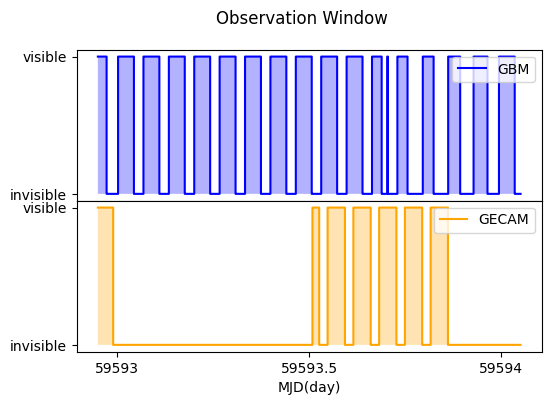

In [17]:
# observe window figure
import numpy as np
import matplotlib.pyplot as plt

GBM_GECAM = [59593.820935567,59593.823009803]
GECAM = [59593.168248032,59593.831165509,59593.837585648,59593.838229745,59593.842190972,59593.844379629,59593.847976273,59593.849715277,59593.851971064,59593.853556134,59593.855438657]
GBM = [59593.026604212,59593.168497777,59593.276351145,59593.344459756,59593.476883726,59593.485900509,59593.557705925,59593.565626886,59593.672723356,59593.810609618,59593.861978067,59593.865468101,59593.865480439,59593.865659062,59593.872540763,59593.931589814,59593.931635775,59593.943359502,59593.949247291]

GBM_win_start = [59592.54002,59592.6061,59592.67218,59592.71188,59592.73826,59592.80434,59592.87041,59592.93649,59593.00257,59593.06865,59593.13473,59593.20081,59593.26688,59593.33296,59593.39904,59593.46511,59593.53119,59593.59728,59593.66335,59593.70305,59593.72943,59593.79551,59593.86158,59593.92766,59593.99374,59594.05981,59594.12589,59594.19196,59594.25804,59594.32412,59594.39019,59594.45627,59594.52235]
GBM_win_end = [59592.5814,59592.64749,59592.69818,59592.71356,59592.76538,59592.83321,59592.90207,59592.97275,59593.04384,59593.11005,59593.17614,59593.24222,59593.30831,59593.37438,59593.44047,59593.50655,59593.57264,59593.63871,59593.68852,59593.7048,59593.75583,59593.82367,59593.89282,59593.96386,59594.03473,59594.10129,59594.16738,59594.23346,59594.29955,59594.36562,59594.43171,59594.49779,59594.56387]
GECAM_win_start = [59592.57167,59592.6092,59592.67625,59592.7433,59592.81034,59592.87738,59592.94443,59593.50837,59593.54784,59593.61488,59593.68192,59593.74897,59593.81601,59594.31994,59594.36845,59594.43834,59594.50781,59594.55344]
GECAM_win_end = [59592.58775,59592.65478,59592.72178,59592.7888,59592.85582,59592.92282,59592.98984,59593.52594,59593.59295,59593.65997,59593.72697,59593.79398,59593.861,59594.33006,59594.39707,59594.45696,59594.53109,59594.59809]

x = np.round(np.arange(59592.95, 59594.05+1e-5, 1e-5),5)
y_gbm = np.zeros(len(x))
y_gecam = np.zeros(len(x))
for i in range(len(GBM_win_start)):
    y_gbm[np.where( (GBM_win_start[i]<=x) & (x<GBM_win_end[i]) )[0]] = 1
for j in range(len(GECAM_win_start)):
    y_gecam[np.where( (GECAM_win_start[j]<=x) & (x<GECAM_win_end[j]) )[0]] = 1


fig, axs = plt.subplots(figsize=(6, 4), dpi=100, sharex=True)
fig.subplots_adjust(hspace=0)

plt.subplot(2, 1, 1)
plt.step(x,y_gbm,where='post',color='blue', label='GBM')
plt.fill_between(x, 0, y_gbm, facecolor='blue', alpha=0.3)
plt.xticks([59593,59593.5,59594],[59593,59593.5,59594])
plt.yticks([0,1],['invisible','visible'])
# plt.xlabel('MJD(day)');# plt.ylabel('Observation state')
plt.legend(loc=1)

plt.subplot(2, 1, 2)
plt.step(x,y_gecam,where='post',color='orange', label='GECAM')
plt.fill_between(x, 0, y_gecam, facecolor='orange', alpha=0.3)
plt.xticks([59593,59593.5,59594],[59593,59593.5,59594])
plt.yticks([0,1],['invisible','visible'])
plt.xlabel('MJD(day)')
plt.suptitle('Observation Window')
plt.legend(loc=1)

plt.savefig('figure/OW.pdf', format='pdf')
plt.show()